<a href="https://colab.research.google.com/github/ANANDHAKUMAR11223/MINI-PROJECT/blob/main/copd1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install noisereduce


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout, Reshape, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# Define a function to extract MFCC features from audio files
def extract_mfcc_features(audio_file, n_mfcc=40):
    y, sr = librosa.load(audio_file, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

# Define a function to load data from the specified directory
def load_data(data_dir, n_mfcc=40):
    features, labels = [], []
    for label, subdir in enumerate(['healthy', 'unhealthy']):
        subdir_path = os.path.join(data_dir, subdir)
        for filename in os.listdir(subdir_path):
            if filename.endswith('.wav'):
                audio_file = os.path.join(subdir_path, filename)
                mfccs = extract_mfcc_features(audio_file, n_mfcc)
                features.append(mfccs)
                labels.append(label)
    return np.array(features), np.array(labels)


In [ ]:
# Load data from the specified directory
data_dir = '/content/drive/MyDrive/lung_sound_final/train'
X, y = load_data(data_dir)

# Encode the labels to categorical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Expand dimensions for the CNN input
X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)


In [ ]:
# Define the CNN-GRU model with additional improvements
model = Sequential([
    Reshape((40, 1), input_shape=(40,)),  # Reshape for Conv1D layer
    Conv1D(32, 2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(64, 2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Reshape((-1, 64)),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(32),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)                  │ (None, 40, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 39, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 39, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 18, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 18, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 9, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,074 (152.63 KB)

 Trainable params: 38,882 (151.88 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Training the model
history = model.fit(
    X_train_expanded, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test_expanded, y_test)
)


Epoch 1/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7256 - loss: 0.5356 - val_accuracy: 0.8179 - val_loss: 0.4521
Epoch 2/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8516 - loss: 0.3455 - val_accuracy: 0.8102 - val_loss: 0.3344
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8846 - loss: 0.2838 - val_accuracy: 0.8302 - val_loss: 0.3368
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9135 - loss: 0.2207 - val_accuracy: 0.8873 - val_loss: 0.2487
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9053 - loss: 0.2401 - val_accuracy: 0.8951 - val_loss: 0.2191
Epoch 6/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9162 - loss: 0.2119 - val_accuracy: 0.9105 - val_loss: 0.2059
Epoch 7/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9139 - loss: 0.2068 - val_accuracy: 0.8966 - val_loss: 0.2145
Epoch 8/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9207 - loss: 0.1930 - val_accuracy: 0.9198 - v

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9381 - loss: 0.1732
Test accuracy: 0.93


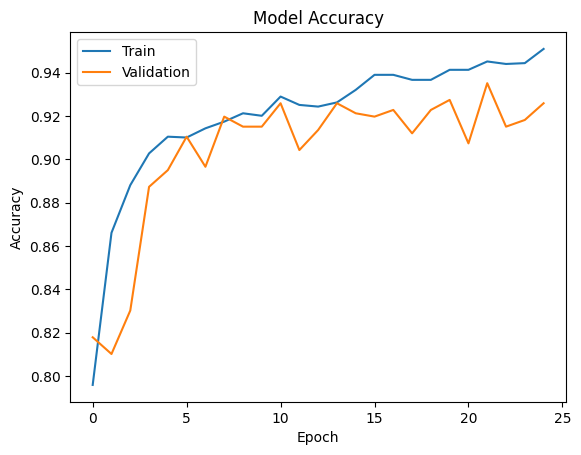

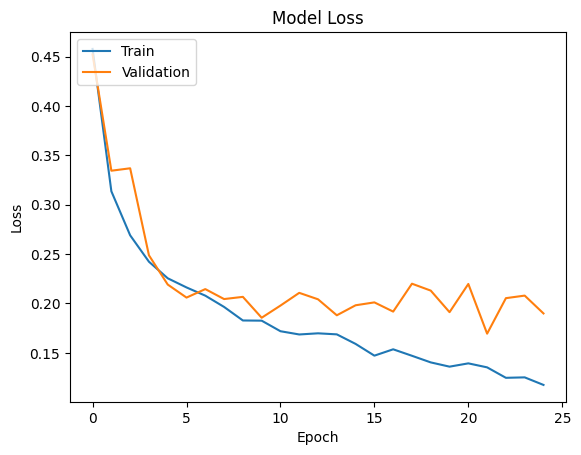

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_expanded, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Example true labels and predicted labels
y_true = np.array([0, 1, 1, 0, 1, 1, 0, 0, 1, 0])  # True labels
y_pred = np.array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0])  # Predicted labels

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert the report into a DataFrame
report_df = pd.DataFrame(report).transpose()

# Select relevant columns and reset index
report_df = report_df[['precision', 'recall', 'f1-score']]
report_df.reset_index(inplace=True)

# Display the table
print(report_df)


          index  precision  recall  f1-score
0             0        0.8     0.8       0.8
1             1        0.8     0.8       0.8
2      accuracy        0.8     0.8       0.8
3     macro avg        0.8     0.8       0.8
4  weighted avg        0.8     0.8       0.8


In [ ]:
import numpy as np
import librosa
# Function to predict lung condition from an audio file
def predict_lung_condition(audio_file, model):
    # Preprocess the audio file
    features = preprocess_audio(audio_file)

    # Reshape the features to match the model's input shape
    features_expanded = np.expand_dims(features, axis=0)

    # Predict the probability distribution
    prediction = model.predict(features_expanded)

    # Get the predicted class and its probability
    predicted_class = np.argmax(prediction, axis=1)[0]
    probability = prediction[0][predicted_class] * 100

    # Map the predicted class to the corresponding condition
    condition_map = {0: "Non-COPD", 1: "COPD"}  # Adjust this mapping based on your classes
    predicted_condition = condition_map[predicted_class]

    # Return the result in the desired format
    return f"The predicted lung condition is {predicted_condition} with a probability of {probability:.2f}%."

In [ ]:
# Example usage
new_audio_file = '/content/drive/MyDrive/heart_sound/val/unhealthy/a0005.wav'  # Replace with the path to your audio file
condition = predict_lung_condition(new_audio_file, model)
print(condition)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The predicted lung condition is COPD with a probability of 62.65%.


In [ ]:
# Example usage
new_audio_file = '/content/drive/MyDrive/heart_sound/val/unhealthy/a0043.wav'  # Replace with the path to your audio file
condition = predict_lung_condition(new_audio_file, model)
print(condition)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The predicted lung condition is COPD with a probability of 85.20%.


In [ ]:
new_audio_file = '/content/drive/MyDrive/heart_sound/val/healthy/c0006.wav'
condition = predict_lung_condition(new_audio_file, model)
print(condition)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The predicted lung condition is Non-COPD with a probability of 84.92%.


In [ ]:
import os

# Define the paths to your two folders
non_copd_folder = '/content/drive/MyDrive/lung_sound_final/train/healthy'  # Replace with the actual path to the Non-COPD folder
copd_folder = '/content/drive/MyDrive/lung_sound_final/train/unhealthy'  # Replace with the actual path to the COPD folder

# Count the number of files in each folder
count_non_copd_files = len([f for f in os.listdir(non_copd_folder) if os.path.isfile(os.path.join(non_copd_folder, f))])
count_copd_files = len([f for f in os.listdir(copd_folder) if os.path.isfile(os.path.join(copd_folder, f))])

print(f'Number of Non-COPD (healthy) audio files: {count_non_copd_files}')
print(f'Number of COPD (unhealthy) audio files: {count_copd_files}')


Number of Non-COPD (healthy) audio files: 2575
Number of COPD (unhealthy) audio files: 665


In [ ]:
import os

# Path to your folder in Google Drive
folder_path = '/content/drive/MyDrive/lung_sound_final/val'

# Define the paths for healthy and unhealthy folders
healthy_folder = os.path.join(folder_path, 'healthy')
unhealthy_folder = os.path.join(folder_path, 'unhealthy')

# Count files in healthy folder
healthy_count = len(os.listdir(healthy_folder))

# Count files in unhealthy folder
unhealthy_count = len(os.listdir(unhealthy_folder))

# Print the counts
print(f'Number of healthy audio files: {healthy_count}')
print(f'Number of unhealthy audio files: {unhealthy_count}')


Number of healthy audio files: 150
Number of unhealthy audio files: 151


In [ ]:
import os
import librosa

# Mount Google Drive
from google.colab import drive
#drive.mount('/content/drive')

# Path to your folder in Google Drive
folder_path = '/content/drive/MyDrive/lung_sound_final/train'

# Define the paths for healthy and unhealthy folders
healthy_folder = os.path.join(folder_path, 'healthy')
unhealthy_folder = os.path.join(folder_path, 'unhealthy')

# Function to get duration of audio files
def get_audio_duration(folder):
    durations = []
    for filename in os.listdir(folder):
        if filename.endswith(('.wav', '.mp3', '.flac')):  # Add other audio formats if needed
            file_path = os.path.join(folder, filename)
            # Load audio file
            duration = librosa.get_duration(filename=file_path)  # Duration in seconds
            durations.append(duration)
    return durations

# Get durations for both folders
healthy_durations = get_audio_duration(healthy_folder)
unhealthy_durations = get_audio_duration(unhealthy_folder)

# Count files
healthy_count = len(healthy_durations)
unhealthy_count = len(unhealthy_durations)

# Define function to categorize duration ranges
def categorize_durations(durations):
    categorized = {}
    for duration in durations:
        if duration < 60:
            range_label = 'Less than 60 seconds'
        elif 60 <= duration < 90:
            range_label = '60 to 90 seconds'
        elif 90 <= duration < 120:
            range_label = '90 to 120 seconds'
        else:
            range_label = 'More than 120 seconds'

        if range_label not in categorized:
            categorized[range_label] = 0
        categorized[range_label] += 1

    return categorized

# Categorize durations
healthy_categories = categorize_durations(healthy_durations)
unhealthy_categories = categorize_durations(unhealthy_durations)

# Print results
print(f'Number of healthy audio files: {healthy_count}')
print(f'Duration categories for healthy audio files: {healthy_categories}')
print(f'Number of unhealthy audio files: {unhealthy_count}')
print(f'Duration categories for unhealthy audio files: {unhealthy_categories}')


<ipython-input-9-3dde3cbba47b>:22: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_path)  # Duration in seconds


Number of healthy audio files: 2575
Duration categories for healthy audio files: {'Less than 60 seconds': 2547, '90 to 120 seconds': 9, '60 to 90 seconds': 19}
Number of unhealthy audio files: 665
Duration categories for unhealthy audio files: {'Less than 60 seconds': 652, 'More than 120 seconds': 1, '60 to 90 seconds': 10, '90 to 120 seconds': 2}


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


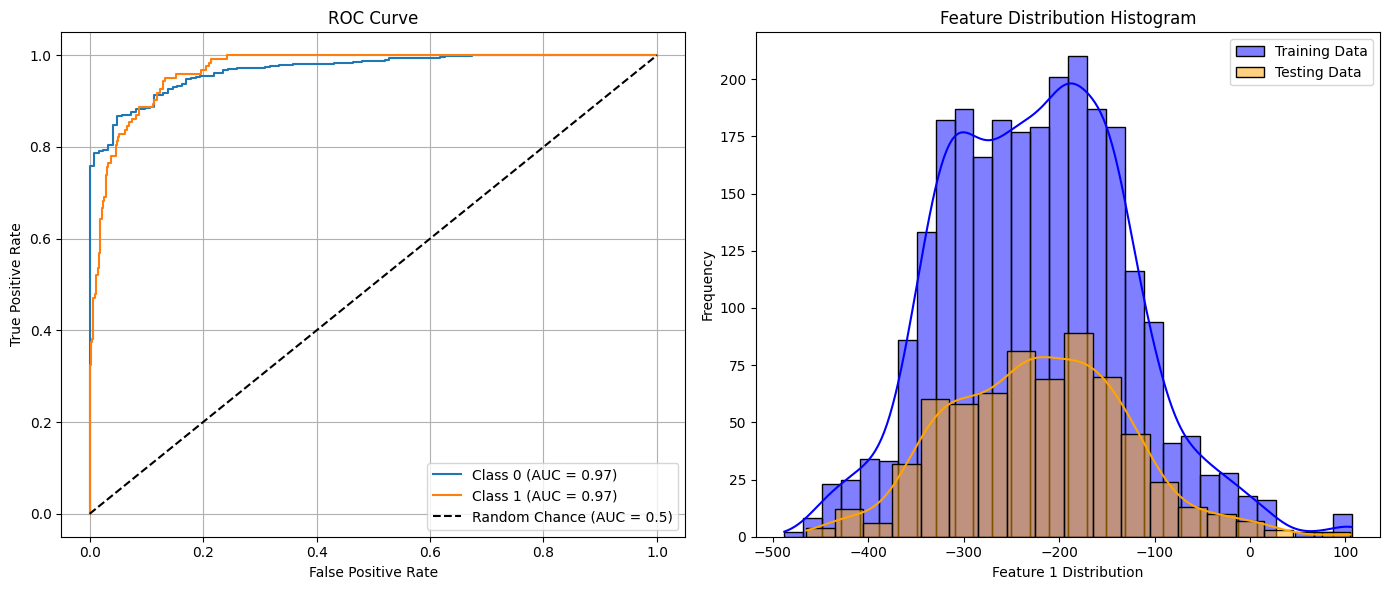

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# --- ROC Curve ---
# Binarize the true labels if they are categorical
y_test_binary = np.argmax(y_test, axis=1)
y_pred_probs = model.predict(X_test_expanded)

# Initialize dictionaries to store ROC values for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(14, 6))

# ROC Curve Plot
plt.subplot(1, 2, 1)
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

# --- Feature Distribution Histogram ---
# Feature Distribution for a chosen feature (e.g., first feature)
chosen_feature_index = 0  # You can change this to visualize other features

plt.subplot(1, 2, 2)
sns.histplot(X_train[:, chosen_feature_index], kde=True, color='blue', label='Training Data')
sns.histplot(X_test[:, chosen_feature_index], kde=True, color='orange', label='Testing Data')
plt.xlabel(f'Feature {chosen_feature_index + 1} Distribution')
plt.ylabel('Frequency')
plt.title('Feature Distribution Histogram')
plt.legend()

# Show the combined plot
plt.tight_layout()
plt.show()


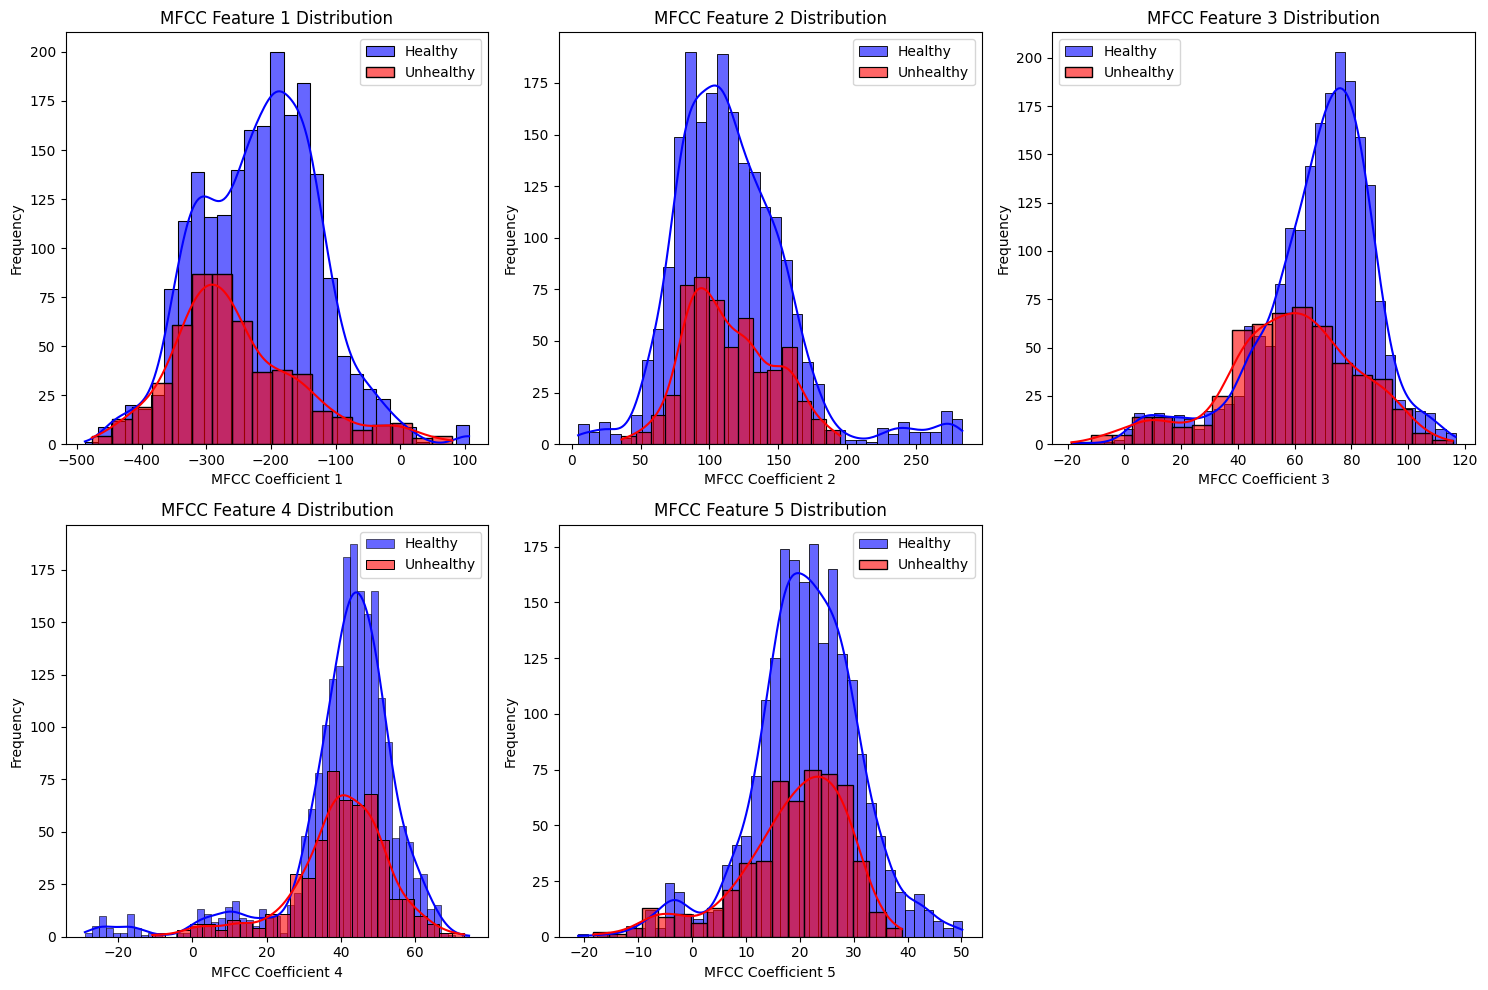

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select specific MFCC features to visualize (e.g., first 5 coefficients)
num_features_to_plot = 5

# Separate features by class
healthy_mfcc = X_train[np.argmax(y_train, axis=1) == 0]
unhealthy_mfcc = X_train[np.argmax(y_train, axis=1) == 1]

plt.figure(figsize=(15, 10))
for i in range(num_features_to_plot):
    plt.subplot(2, 3, i + 1)  # Arrange subplots in a grid
    sns.histplot(healthy_mfcc[:, i], color='blue', kde=True, label='Healthy', alpha=0.6)
    sns.histplot(unhealthy_mfcc[:, i], color='red', kde=True, label='Unhealthy', alpha=0.6)
    plt.title(f'MFCC Feature {i + 1} Distribution')
    plt.xlabel(f'MFCC Coefficient {i + 1}')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()
